In [18]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import datetime
import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sqlite3 
from matplotlib.ticker import PercentFormatter

## Reading Data

In [2]:
data_path = '/Users/jenniferwu/Desktop/MSBA/Spring 2020/Predictive/fp_dat/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

## Merging Data and Create Master Datafile (Full_DF)

In [3]:
import warnings
warnings.simplefilter('ignore')

##cleaning the submission dataset - adding store id to join data later
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

##adding DAY OF WEEK to reservation data
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek

hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

#create LAG VARIABLE (for forecasting period) = time between RESERVATION DATE to VISIT DATE 


#create "id" col as join key
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)


data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek

#adding holiday flag
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

#create interaction terms between holiday flag x weekday


air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

In [4]:
full_df = air_visit.merge(store_id_map, how='inner', right_on= "air_store_id",left_on = "store_id")\
                .merge(hpg_reserve.loc[:,['store_id','reserve_visitors','visit_date','reserve_date','dow']], how = 'inner', on = ['store_id','visit_date'])\
                .merge(air_reserve.loc[:,['store_id','visit_date','reserve_date','reserve_visitors']], how = 'inner', on = ['store_id','visit_date'])

In [5]:
full_df.rename(columns={'reserve_visitors_x':'reserve_visitor_hpg',
                        'reserve_date_x': 'reserve_date_hpg',
                        'reserve_date_y': 'reserve_date_air',
                        'reserve_visitors_y': 'reserve_visitors_air'
                       }, inplace=True)

In [6]:
full_df = full_df.merge(air_store.loc[:,['store_id','air_genre_name','air_area_name','air_area_name0']], how='inner', on='store_id').\
          merge(hpg_store.loc[:,['store_id','air_genre_name']], how='inner', on='store_id')

In [7]:
full_df=full_df.rename(columns={'air_genre_name_y':'air_genre_name',
                       'air_genre_name_x':'air_genre_name0'})

In [8]:
full_df.head()

,store_id,visit_date,visitors,id,air_store_id,hpg_store_id,reserve_visitor_hpg,reserve_date_hpg,dow,reserve_date_air,reserve_visitors_air,air_genre_name0,air_area_name,air_area_name0,air_genre_name
0,air_37189c92b6c761ec,2016-02-08,6,air_37189c92b6c761ec_2016-02-08,air_37189c92b6c761ec,hpg_2e10e1956528199a,7,2016-02-07,0,2016-02-08,2,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine
1,air_37189c92b6c761ec,2016-03-12,30,air_37189c92b6c761ec_2016-03-12,air_37189c92b6c761ec,hpg_2e10e1956528199a,3,2016-03-11,5,2016-03-11,3,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine
2,air_37189c92b6c761ec,2016-03-14,8,air_37189c92b6c761ec_2016-03-14,air_37189c92b6c761ec,hpg_2e10e1956528199a,2,2016-03-14,0,2016-03-14,2,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine
3,air_37189c92b6c761ec,2016-03-14,8,air_37189c92b6c761ec_2016-03-14,air_37189c92b6c761ec,hpg_2e10e1956528199a,2,2016-03-11,0,2016-03-14,2,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine
4,air_37189c92b6c761ec,2016-03-21,4,air_37189c92b6c761ec_2016-03-21,air_37189c92b6c761ec,hpg_2e10e1956528199a,2,2016-03-19,0,2016-03-19,2,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine


## Top Genre and Location Based on Number of Visits

In [9]:
#%load_ext sql
conn = sqlite3.connect(':memory:')
full_df.to_sql('full_df', conn, index=False)

In [10]:
qry = '''
    select air_genre_name, air_genre_name0, air_area_name, air_area_name0,
    count(distinct store_id) as store,
    sum(visitors) as visitors
    from full_df  
    group by 1,2,3,4
    '''
df = pd.read_sql_query(qry,conn)

In [11]:
df.head()

,air_genre_name,air_genre_name0,air_area_name,air_area_name0,store,visitors
0,Amusement bar,1,Hokkaidō Sapporo-shi Minami 3 Jōnishi,2,1,7550
1,Cafe,1,Hiroshima-ken Hiroshima-shi Kokutaijimachi,1,1,2984
2,Creation,4,Tōkyō-to Shibuya-ku Shibuya,7,1,1336
3,Creation,7,Fukuoka-ken Kitakyūshū-shi None,0,1,2456
4,Creation,7,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,3,1,9827


## Top Genre Based on Number of visits

In [99]:
top_genre = df.groupby(['air_genre_name'], as_index=False).agg({"visitors":"sum",
                                                                                  "store":"sum"})
top_genre['visit_per_store']=top_genre.visitors/top_genre.store
top_genre= top_genre.sort_values(by=['visit_per_store'],ascending=False).reset_index(drop=True)
top_genre['cummulative_visitsperstore']=top_genre.visit_per_store.cumsum()/sum(top_genre.visit_per_store)
top80_genre=top_genre[top_genre.cummulative_visitsperstore <= .85]
top80_genre.to_csv("top80genre.csv")

In [100]:
pal = sns.color_palette("husl",9)
pal_set = pal.as_hex()

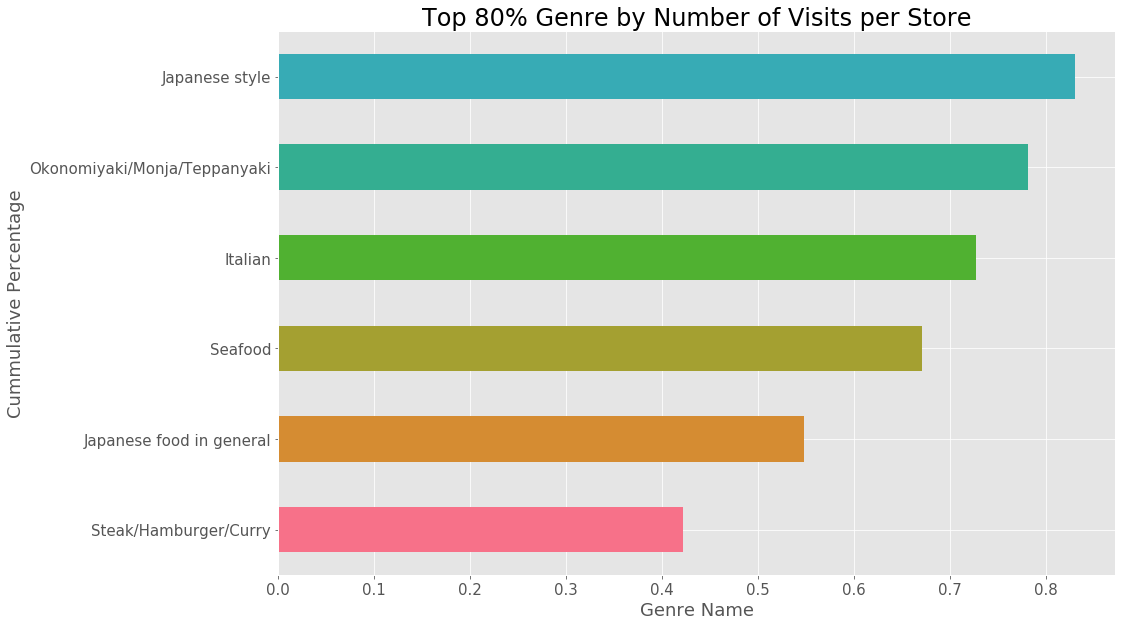

In [101]:
plt.style.use('ggplot')
top80_genre.plot.barh(x='air_genre_name', 
            y='cummulative_visitsperstore',
            legend=False,figsize=(15,10),color=pal_set)
plt.title("Top 80% Genre by Number of Visits per Store", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genre Name",fontsize=18)
plt.ylabel("Cummulative Percentage",fontsize=18)
plt.show()

In [102]:
top80_genre

,air_genre_name,visitors,store,visit_per_store,cummulative_visitsperstore
0,Steak/Hamburger/Curry,130075,1,130075.000000,0.422150
1,Japanese food in general,38702,1,38702.000000,0.547755
2,Seafood,113670,3,37890.000000,0.670725
3,Italian,86643,5,17328.600000,0.726964
4,Okonomiyaki/Monja/Teppanyaki,16610,1,16610.000000,0.780870
5,Japanese style,274299,18,15238.833333,0.830327


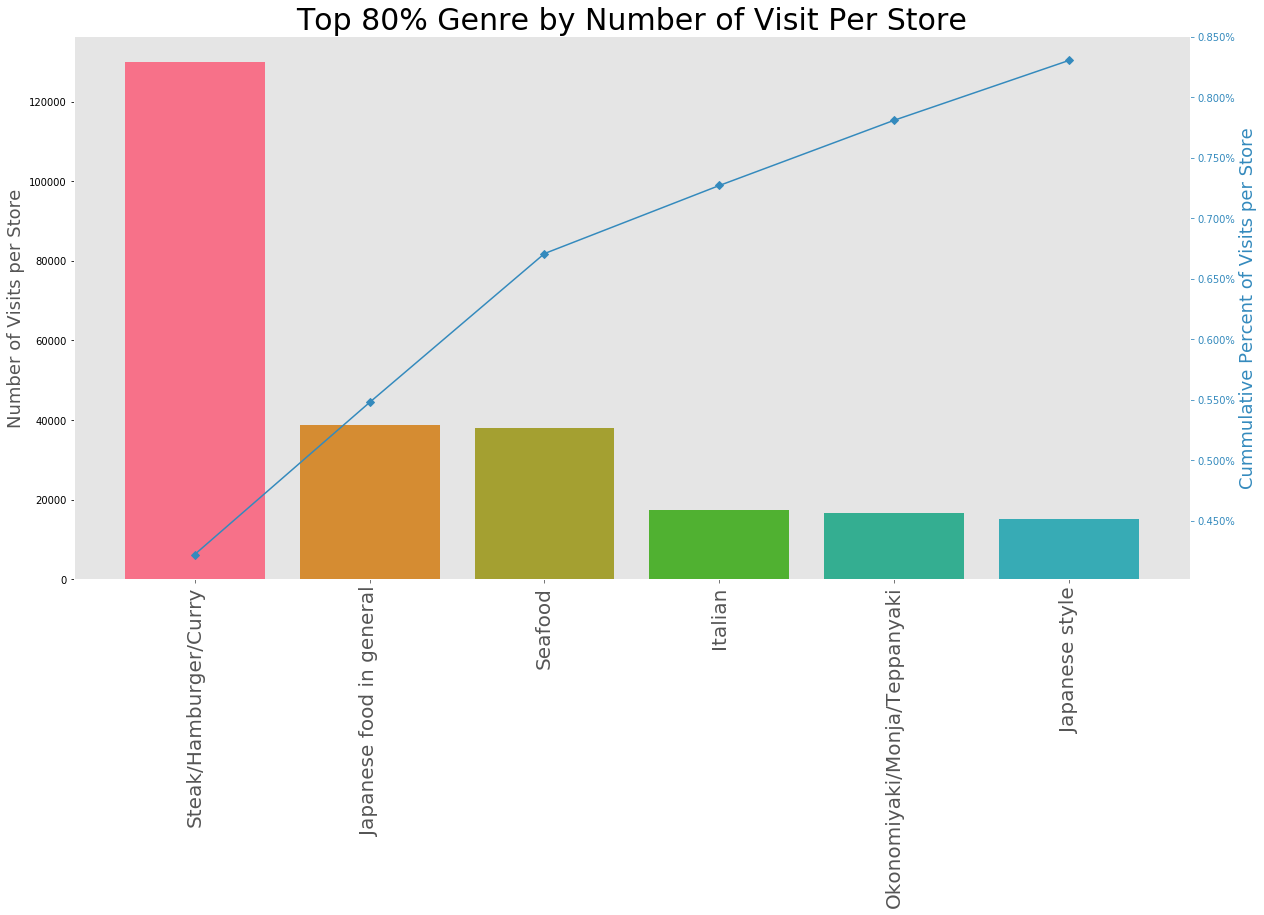

In [106]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))


ax.bar(top80_genre.air_genre_name, top80_genre["visit_per_store"], color=pal_set)
ax2 = ax.twinx()
ax2.plot(top80_genre.air_genre_name, top80_genre["cummulative_visitsperstore"], color="C1", marker="D")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)

ax.tick_params(axis="y", colors="black")
ax2.tick_params(axis="y", colors="C1")
ax.tick_params(axis="x", rotation=90)

ax.set_xticklabels(top80_genre.air_genre_name,fontsize= 20)
ax.set_ylabel("Number of Visits per Store", fontsize = 18)
ax2.set_ylabel("Cummulative Percent of Visits per Store", color="C1",fontsize = 18)
ax.set_title("Top 80% Genre by Number of Visit Per Store",fontsize= 30)
ax.grid(False)


plt.show()

In [15]:
top_loc = df.groupby(['air_area_name','air_area_name0'], as_index=False).agg({"visitors":"sum",
                                                                                  "store":"sum"})
top_loc['visit_per_store']=top_loc.visitors/top_loc.store
top_loc= top_loc.sort_values(by=['visit_per_store'],ascending=False).reset_index(drop=True)
top_loc['cummulative_visitsperstore']=top_loc.visit_per_store.cumsum()/sum(top_loc.visit_per_store)
top80_area=top_loc[top_loc.cummulative_visitsperstore <= .80]
top80_area

,air_area_name,air_area_name0,visitors,store,visit_per_store,cummulative_visitsperstore
0,Hokkaidō Sapporo-shi Kotoni 2 Jō,2,77796,1,77796.000000,0.181229
1,Hyōgo-ken Himeji-shi Yasuda,3,38702,1,38702.000000,0.271386
2,Hokkaidō Asahikawa-shi 6 Jōdōri,2,111644,3,37214.666667,0.358079
3,Hokkaidō Sapporo-shi Minami 3 Jōnishi,2,145616,4,36404.000000,0.442884
4,Shizuoka-ken Hamamatsu-shi Motoshirochō,6,30257,1,30257.000000,0.513369
5,Tōkyō-to Chūō-ku Ginza,7,29948,1,29948.000000,0.583133
6,Ōsaka-fu Ōsaka-shi Ōgimachi,8,59220,2,29610.000000,0.652111
7,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,5,63005,3,21001.666667,0.701035
8,Ōsaka-fu Ōsaka-shi Shinmachi,8,31778,2,15889.000000,0.738049
9,Hiroshima-ken Hiroshima-shi Kokutaijimachi,1,40803,3,13601.000000,0.769733


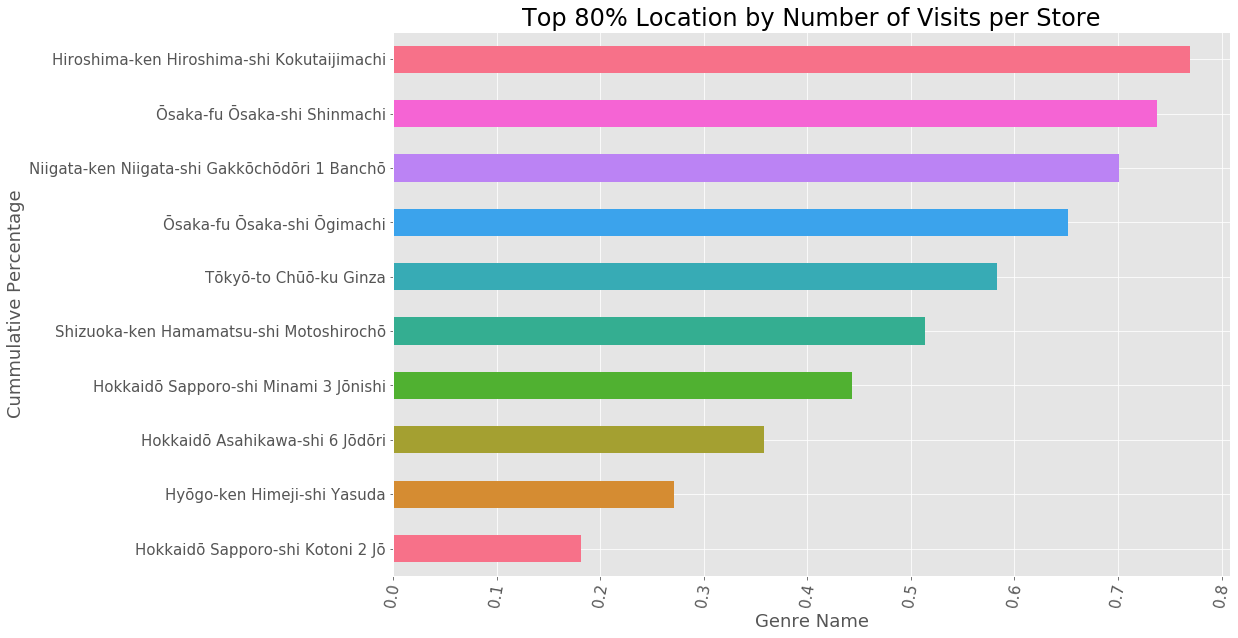

In [16]:
plt.style.use('ggplot')
top80_area.plot.barh(x='air_area_name', 
            y='cummulative_visitsperstore',
            legend=False,figsize=(15,10),color=pal_set)
plt.title("Top 80% Location by Number of Visits per Store", fontsize=24)
plt.xticks(rotation=80
           ,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genre Name",fontsize=18)
plt.ylabel("Cummulative Percentage",fontsize=18)
plt.show()

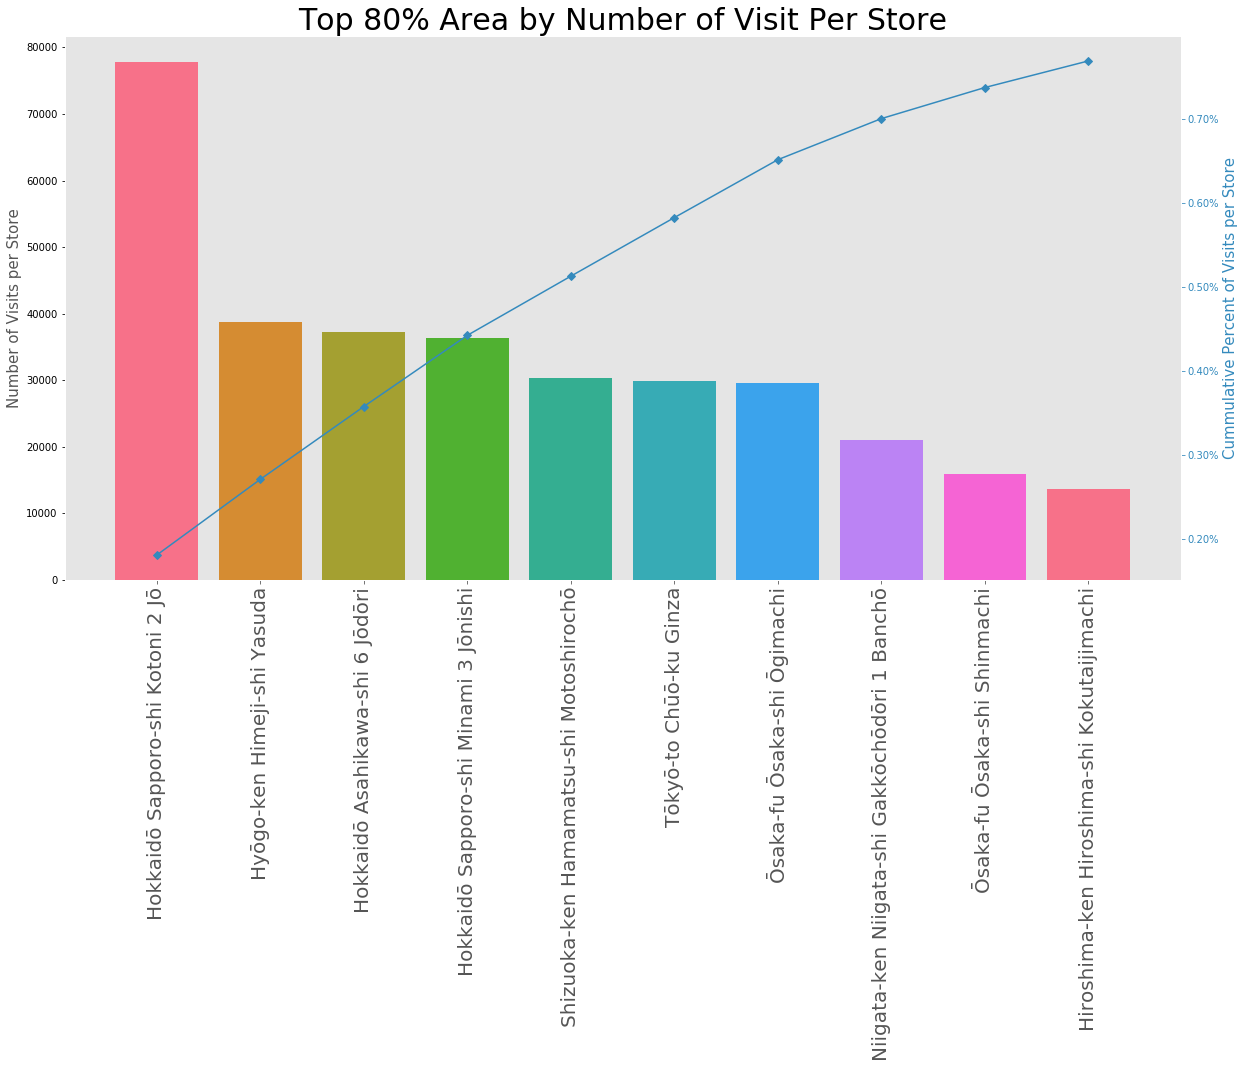

In [107]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))

title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal','verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'14'}

ax.bar(top80_area.air_area_name, top80_area["visit_per_store"], color=pal_set)
ax2 = ax.twinx()
ax2.plot(top80_area.air_area_name, top80_area["cummulative_visitsperstore"], color="C1", marker="D")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(False)
ax.tick_params(axis="y", colors="black")
ax2.tick_params(axis="y", colors="C1")
ax.tick_params(axis="x", rotation=90)


ax.set_xticklabels(top80_area.air_area_name,fontsize= 20)
ax.set_ylabel("Number of Visits per Store", fontsize = 15)
ax2.set_ylabel("Cummulative Percent of Visits per Store", color="C1",fontsize = 15)
ax.set_title("Top 80% Area by Number of Visit Per Store",fontsize= 30)
ax.grid(False)


plt.show()

In [311]:
comb=df[(df.air_genre_name.isin(list(top80_genre.air_genre_name))\
         & df.air_area_name.isin(list(top80_area.air_area_name)))]

In [78]:
#will use this genre and location to rollup the forecast
top80storeID = pd.DataFrame(full_df[(full_df.air_genre_name.isin(list(top80_genre.air_genre_name)) \
            & full_df.air_area_name.isin(list(top80_area.air_area_name)))])\
            .loc[:,['store_id','air_genre_name','air_area_name','visitors']]
#top80storeID.to_csv('top80storeID.csv',index=False)

In [80]:
top80storeID=top80storeID.groupby(['store_id','air_genre_name','air_area_name'], as_index=False).agg({"visitors":"sum"})

labels_genre = top80storeID['air_genre_name'].astype('category').cat.categories.tolist()
replace_with_int_genre = {'air_genre_name' : {k: v for k,v in zip(labels_genre,list(range(0,len(labels_genre))))}}

labels_ar = top80storeID['air_area_name'].astype('category').cat.categories.tolist()
replace_with_int_ar = {'air_area_name' : {k: v for k,v in zip(labels_ar,list(range(0,len(labels_ar))))}}

top80storeID.replace(replace_with_int_genre, inplace=True)
top80storeID.replace(replace_with_int_ar, inplace=True)

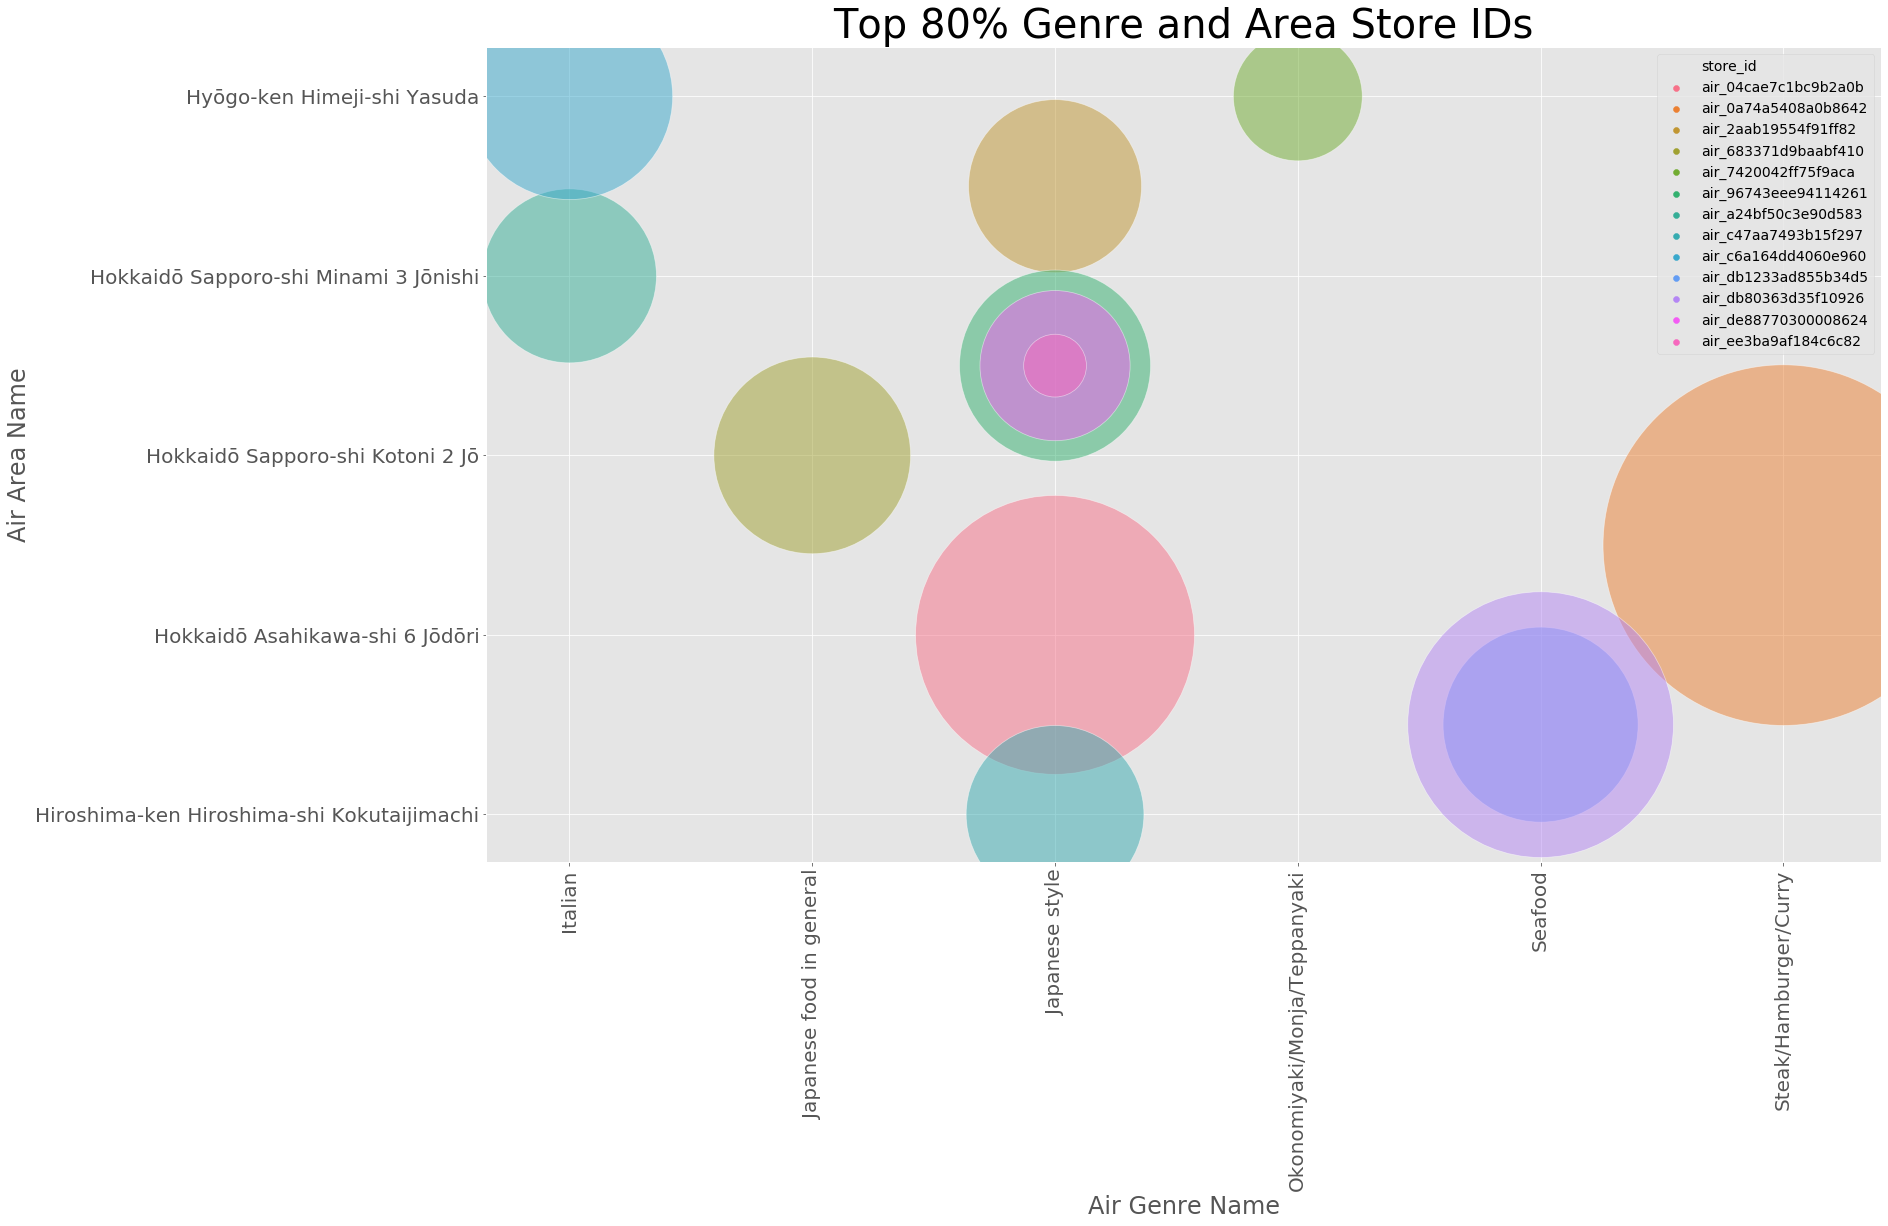

In [110]:
labg=['Italian']
for i in labels_genre:
    labg.append(i)
    
labr=['Hiroshima-ken Hiroshima-shi Kokutaijimachi']
for i in labels_ar:
    labr.append(i)

#Create figure
plt.figure(figsize = (25,15))

# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(top80storeID.air_genre_name, top80storeID.air_area_name,
                     alpha = 0.5,s = top80storeID.visitors,
                     hue=top80storeID.store_id)
plt.title("Top 80% Genre and Area Store IDs", fontsize=40)
plt.ylabel("Air Area Name",fontsize=24)
plt.xlabel("Air Genre Name",fontsize=24)
ax.set_xticklabels(labg, fontsize=20, rotation=90)
ax.set_yticklabels(labr, fontsize=20,)


plt.show()

## Create Lag Analysis from Overall to Japanese Style Genre Level

In [117]:
full_df['visit_date_dt']=[pd.to_datetime(i) for i in full_df.visit_date]
full_df['reserve_date_hpg_dt']=[pd.to_datetime(i)for i in full_df.reserve_date_hpg]
full_df['reserve_date_air_dt']=[pd.to_datetime(i) for i in full_df.reserve_date_air]

In [118]:
full_df['reserve_visit_date_lag_hpg']=full_df.visit_date_dt-full_df.reserve_date_hpg_dt
full_df['reserve_visit_date_lag_air']=full_df.visit_date_dt-full_df.reserve_date_air_dt

In [119]:
full_df['reserve_visit_date_lag_hpg']=full_df['reserve_visit_date_lag_hpg'].dt.total_seconds() / (24 * 60 * 60)
full_df['reserve_visit_date_lag_air']=full_df['reserve_visit_date_lag_air'].dt.total_seconds() / (24 * 60 * 60)

reserve_visit_date_lag_avg = []
for i,j in zip(full_df.reserve_visit_date_lag_hpg,full_df.reserve_visit_date_lag_air):
    if i == 0 or j == 0:
        reserve_visit_date_lag_avg.append(np.max([i,j]))
    else:
        reserve_visit_date_lag_avg.append((i+j)/2)
        
full_df['reserve_visit_date_lag_avg']= [round(i,0) for i in reserve_visit_date_lag_avg]
#full_df.to_csv('full_df.csv')

In [156]:
full_df.head()

,store_id,visit_date,visitors,id,air_store_id,hpg_store_id,reserve_visitor_hpg,reserve_date_hpg,dow,reserve_date_air,...,air_genre_name0,air_area_name,air_area_name0,air_genre_name,visit_date_dt,reserve_date_hpg_dt,reserve_date_air_dt,reserve_visit_date_lag_hpg,reserve_visit_date_lag_air,reserve_visit_date_lag_avg
0,air_37189c92b6c761ec,2016-02-08,6,air_37189c92b6c761ec_2016-02-08,air_37189c92b6c761ec,hpg_2e10e1956528199a,7,2016-02-07,0,2016-02-08,...,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine,2016-02-08,2016-02-07,2016-02-08,1.0,0.0,1.0
1,air_37189c92b6c761ec,2016-03-12,30,air_37189c92b6c761ec_2016-03-12,air_37189c92b6c761ec,hpg_2e10e1956528199a,3,2016-03-11,5,2016-03-11,...,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine,2016-03-12,2016-03-11,2016-03-11,1.0,1.0,1.0
2,air_37189c92b6c761ec,2016-03-14,8,air_37189c92b6c761ec_2016-03-14,air_37189c92b6c761ec,hpg_2e10e1956528199a,2,2016-03-14,0,2016-03-14,...,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine,2016-03-14,2016-03-14,2016-03-14,0.0,0.0,0.0
3,air_37189c92b6c761ec,2016-03-14,8,air_37189c92b6c761ec_2016-03-14,air_37189c92b6c761ec,hpg_2e10e1956528199a,2,2016-03-11,0,2016-03-14,...,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine,2016-03-14,2016-03-11,2016-03-14,3.0,0.0,3.0
4,air_37189c92b6c761ec,2016-03-21,4,air_37189c92b6c761ec_2016-03-21,air_37189c92b6c761ec,hpg_2e10e1956528199a,2,2016-03-19,0,2016-03-19,...,1,Hokkaidō Asahikawa-shi 6 Jōdōri,2,International cuisine,2016-03-21,2016-03-19,2016-03-19,2.0,2.0,2.0


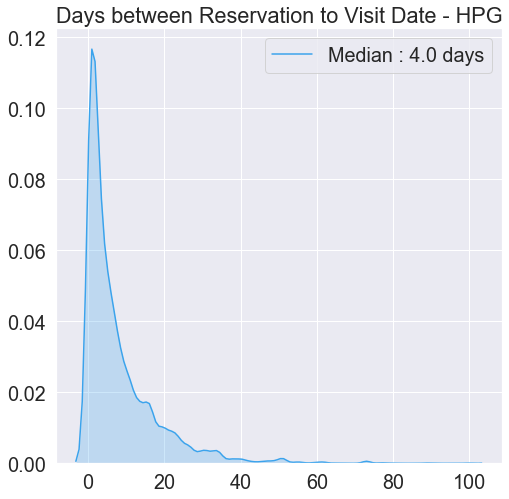

In [161]:
median = np.median(full_df['reserve_visit_date_lag_hpg'])
sns.set(style='darkgrid',font_scale=1.8)
snsplt = plt.figure(figsize=(8,8))
snsplt = plt.title('Days between Reservation to Visit Date - HPG')
snsplt=sns.kdeplot(full_df['reserve_visit_date_lag_hpg'], shade=True,\
                   color="#3ba3ec",label="Median : "+ str(median) + " days")
#p=snsplt.get_figure()
#p.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/wordcnt.png',transparent=True)

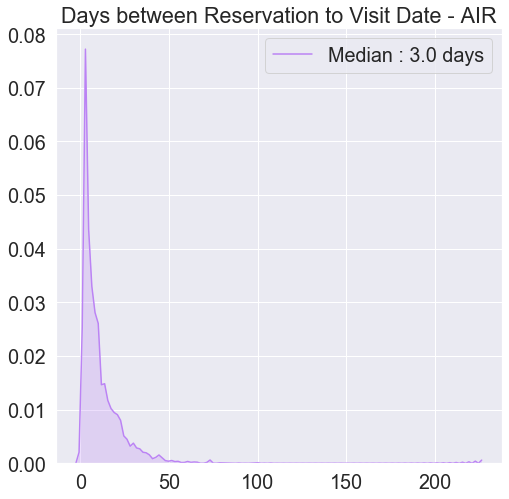

In [160]:
median = round(np.median(full_df['reserve_visit_date_lag_air']),0)
sns.set(style='darkgrid',font_scale=1.8)
snsplt = plt.figure(figsize=(8,8))
snsplt = plt.title('Days between Reservation to Visit Date - AIR')
snsplt=sns.kdeplot(full_df['reserve_visit_date_lag_air'], \
                   shade=True, color="#bb83f4",label="Median : "+ str(median) + " days")
#p=snsplt.get_figure()

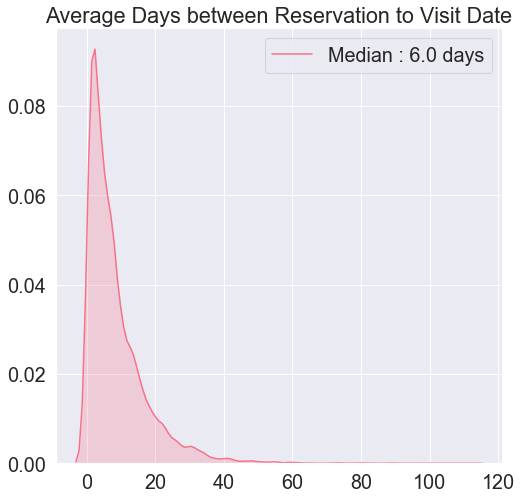

In [159]:
median = np.median(full_df['reserve_visit_date_lag_avg'])
sns.set(style='darkgrid',font_scale=1.8)
snsplt = plt.figure(figsize=(8,8))
snsplt = plt.title('Average Days between Reservation to Visit Date')
snsplt=sns.kdeplot(full_df['reserve_visit_date_lag_avg'], shade=True, \
                   color="#f77189",label="Median : "+ str(median) + " days")

## Lag by Top 80 Genre

In [163]:
top80 = pd.DataFrame(full_df[(full_df.air_genre_name.isin(list(top80_genre.air_genre_name)) \
            & full_df.air_area_name.isin(list(top80_area.air_area_name)))])

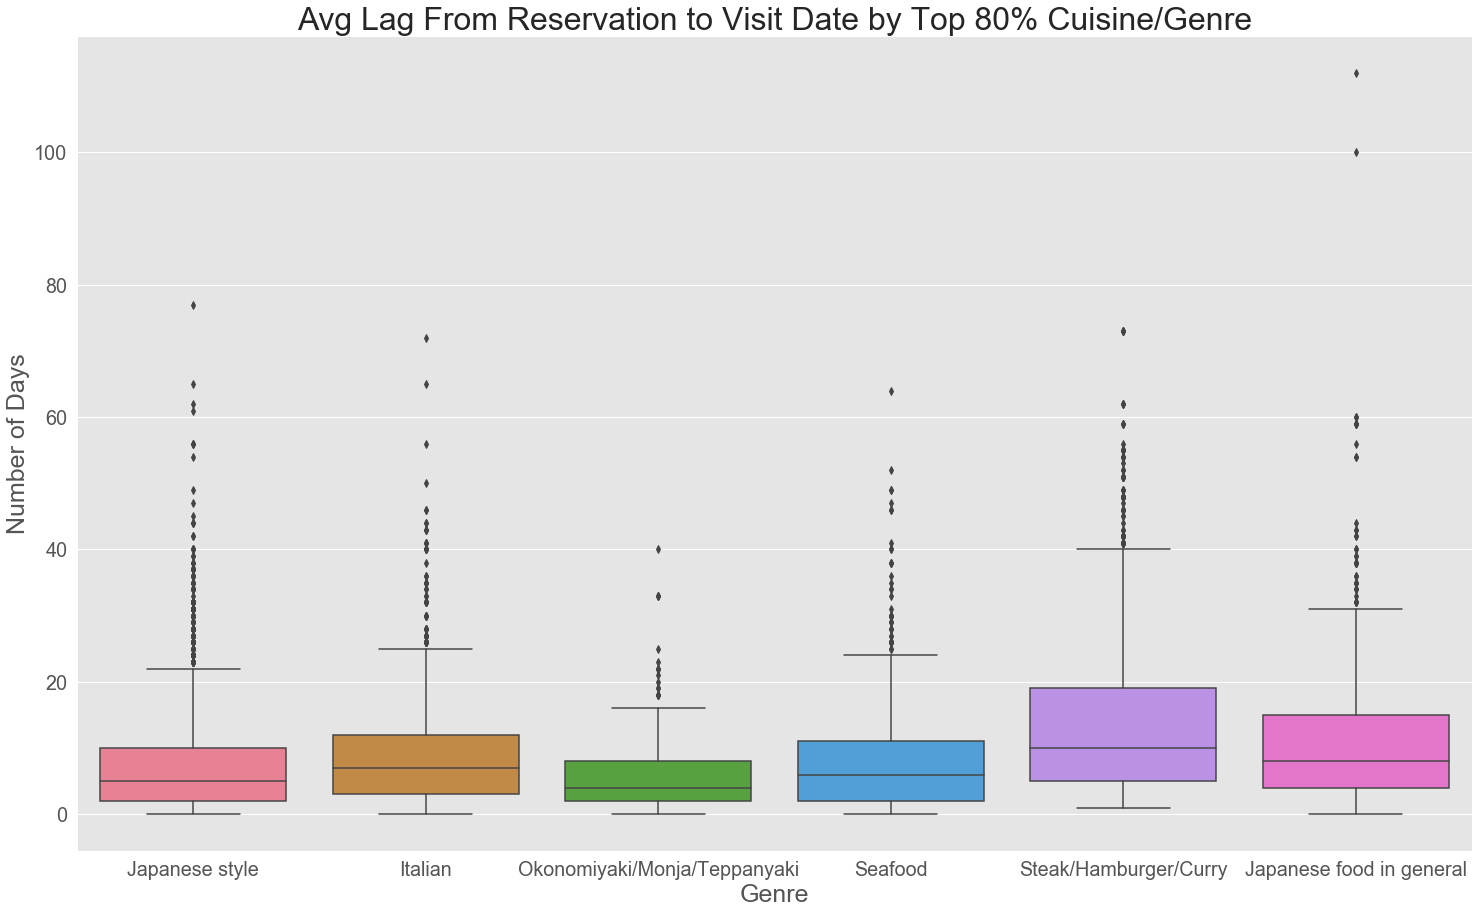

In [206]:
plt.style.use('ggplot')
plt.figure(figsize=(25,15))

sns.boxplot(data=top80, x='air_genre_name', y='reserve_visit_date_lag_avg', 
            palette=pal_set[0:2]+pal_set[3:4]+pal_set[6:9])
plt.ylabel('Number of Days', fontsize=25)
plt.xlabel('Genre', fontsize=25)
plt.title("Avg Lag From Reservation to Visit Date by Top 80% Cuisine/Genre", fontsize=32)
plt.show()

In [216]:
for i in list(top80.air_genre_name.unique()):
    print("Median Lag for", i,":",np.median(top80[top80.air_genre_name==i].reserve_visit_date_lag_avg))

Median Lag for Japanese style : 5.0
Median Lag for Italian : 7.0
Median Lag for Okonomiyaki/Monja/Teppanyaki : 4.0
Median Lag for Seafood : 6.0
Median Lag for Steak/Hamburger/Curry : 10.0
Median Lag for Japanese food in general : 8.0
